In [18]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial
from multiprocessing import Pool
from PIL import Image

In [19]:
def resize_with_aspect_ratio(image, target_size=(512, 512)):
    """
    Resizes an image to fit within a target size while maintaining the aspect ratio.
    Adds padding to center the image on a black background.

    Parameters:
        image (numpy.ndarray): Input image to resize.
        target_size (tuple): Target dimensions (height, width).

    Returns:
        numpy.ndarray: Padded image with the target dimensions.
    """
    # Original and target dimensions
    h, w = image.shape[:2]
    target_h, target_w = target_size
    
    # Calculate scale factor and new dimensions
    scale = min(target_w / w, target_h / h)
    new_dims = (int(w * scale), int(h * scale))
    
    # Resize image and create padded canvas
    resized_image = cv2.resize(image, new_dims, interpolation=cv2.INTER_AREA)
    padded_image = np.full((target_h, target_w, 3), 0, dtype=np.uint8)
    
    # Calculate offsets for centering
    y_offset = (target_h - new_dims[1]) // 2
    x_offset = (target_w - new_dims[0]) // 2
    
    # Place resized image on the canvas
    padded_image[y_offset:y_offset + new_dims[1], x_offset:x_offset + new_dims[0]] = resized_image
    return padded_image

In [20]:
def crop_retina_image(image_bgr, output_size=(512, 512)):
    """
    Crops a retina image to the largest contour's bounding rectangle and resizes it.

    Parameters:
        image_bgr (numpy.ndarray): Input image in BGR format.
        output_size (tuple): Target dimensions (height, width).

    Returns:
        numpy.ndarray: Cropped and resized image in BGR format.
    """
    # Validate the input image
    if image_bgr is None or image_bgr.size == 0:
        raise ValueError("Invalid or empty input image.")

    # Convert to grayscale and threshold to create a binary mask
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Detect contours and validate their presence
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found in the input image.")

    # Crop the largest contour's bounding rectangle
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    cropped = image_bgr[y:y+h, x:x+w]

    # Resize cropped image and return
    return resize_with_aspect_ratio(cropped, target_size=output_size)

In [21]:
def detect_exposure(image_bgr, over_threshold=200, under_threshold=20, exposure_ratio=0.7):
    """
    Detects whether an image is overexposed or underexposed based on pixel intensity thresholds.

    Parameters:
        image_bgr (numpy.ndarray): Input image in BGR format.
        over_threshold (int): Pixel intensity above this value is considered overexposed (default: 200).
        under_threshold (int): Pixel intensity below this value is considered underexposed (default: 20).
        exposure_ratio (float): Maximum allowed ratio of over/underexposed pixels (default: 0.7).

    Returns:
        tuple: 
            - is_not_overexposed (bool): Whether the image is not overexposed.
            - is_not_underexposed (bool): Whether the image is not underexposed.
            - over_ratio (float): Ratio of overexposed pixels.
            - under_ratio (float): Ratio of underexposed pixels.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    # Calculate total pixels and counts of overexposed/underexposed pixels
    total_pixels = gray.size
    overexposed_pixels = np.sum(gray >= over_threshold)
    underexposed_pixels = np.sum(gray <= under_threshold)

    # Compute the ratios of overexposed and underexposed pixels
    over_ratio = overexposed_pixels / total_pixels
    under_ratio = underexposed_pixels / total_pixels

    # Check if the image is within acceptable exposure limits
    is_not_overexposed = over_ratio <= exposure_ratio
    is_not_underexposed = under_ratio <= exposure_ratio

    # Return the results
    return is_not_overexposed, is_not_underexposed, over_ratio, under_ratio

In [22]:
def create_output_folders(base_folder):
    """
    Creates necessary output folders for image categorization.

    Parameters:
        base_folder (str): Path to the base output folder.

    Returns:
        dict: Dictionary with keys ('Underexposed', 'Overexposed', 'Well-exposed') and paths to the corresponding folders.
    """
    # Ensure the base folder exists
    os.makedirs(base_folder, exist_ok=True)

    # Define and create subfolders
    folders = {"Underexposed": os.path.join(base_folder, "Underexposed"),
               "Overexposed": os.path.join(base_folder, "Overexposed"),
               "Well-exposed": os.path.join(base_folder, "Well-exposed")}
    for path in folders.values():
        os.makedirs(path, exist_ok=True)

    # Return the dictionary of folder paths
    return folders

In [23]:
def categorize_and_save_image(image_bgr, image_name, exposure_results, output_folders):
    """
    Categorizes an image based on exposure results and saves it in the appropriate folder.

    Parameters:
        image_bgr (numpy.ndarray): Image in BGR format to be saved.
        image_name (str): Name for the saved image file (without extension).
        exposure_results (tuple): Exposure results as (is_not_overexposed, is_not_underexposed, over_ratio, under_ratio).
        output_folders (dict): Dictionary of output folder paths with keys ('Underexposed', 'Overexposed', 'Well-exposed').

    Returns:
        tuple: 
            - category (str): Exposure category ('Well-exposed', 'Overexposed', 'Underexposed', or 'Error').
            - output_path (str or None): Path where the image was saved, or None if an error occurred.
            - over_ratio (float): Ratio of overexposed pixels.
            - under_ratio (float): Ratio of underexposed pixels.
    """
    # Unpack exposure results
    is_not_overexposed, is_not_underexposed, over_ratio, under_ratio = exposure_results

    # Determine the category based on exposure results
    if is_not_overexposed and is_not_underexposed:
        category = "Well-exposed"
    elif not is_not_overexposed:
        category = "Overexposed"
    elif not is_not_underexposed:
        category = "Underexposed"
    else:
        return "Error", None, over_ratio, under_ratio

    # Construct the output path for the image
    output_path = os.path.join(output_folders[category], f"{image_name}.jpeg")

    # Save the image in BGR format directly
    cv2.imwrite(output_path, image_bgr)

    # Return the category, path, and exposure ratios
    return category, output_path, over_ratio, under_ratio

In [24]:
def process_images_with_histogram_statistics(image_folder, csv_path, output_folder, output_size=(512, 512)):
    """
    Main processing pipeline for images with histogram statistics.
    Processes images, extracts histograms, calculates exposure, and categorizes them.

    Parameters:
        image_folder (str): Path to the folder containing input images.
        csv_path (str): Path to the CSV file containing image metadata.
        output_folder (str): Path to the folder to save categorized images.
        output_size (tuple): Target size for image resizing (default: (512, 512)).

    Returns:
        tuple: 
            - pd.DataFrame: Results with image metadata and categorization.
            - np.ndarray: Aggregated histogram (mean of all histograms).
            - np.ndarray: Standard deviation of histograms.
    """
    # Create necessary output folders
    output_folders = create_output_folders(output_folder)

    # Load metadata
    labels_df = pd.read_csv(csv_path)
    labels_df["image_path"] = labels_df["image"].apply(lambda x: os.path.join(image_folder, f"{x}.jpeg"))

    # Process each image
    per_image_histograms = []
    results = []

    for _, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Processing Images"):
        process_single_image(row, results, per_image_histograms, output_size)

    # Compute aggregated histogram statistics
    aggregated_histogram = None
    std_histogram = None
    if per_image_histograms:
        aggregated_histogram = np.mean(per_image_histograms, axis=0)
        std_histogram = np.std(per_image_histograms, axis=0)
        
    # Categorize and save images
    final_results = categorize_images(results, output_folders)

    return pd.DataFrame(final_results), aggregated_histogram, std_histogram


def process_single_image(row, results, per_image_histograms, output_size):
    """
    Processes a single image: cropping, resizing, and histogram computation.

    Parameters:
        row (pd.Series): Row of the DataFrame containing image metadata.
        results (list): List to store processing results.
        per_image_histograms (list): List to store individual image histograms.
        output_size (tuple): Target size for image resizing.

    Returns:
        None
    """
    image_name, label, image_path = row["image"], row["level"], row["image_path"]

    if not os.path.isfile(image_path):
        results.append({"image": image_name, "label": label, "category": "File not found"})
        return

    try:
        # Load and process the image
        bgr_image = cv2.imread(image_path)
        cropped_bgr = crop_retina_image(bgr_image, output_size)

        if cropped_bgr is None or cropped_bgr.size == 0:
            raise ValueError(f"Invalid cropped image for {image_name}")

        # Convert to grayscale and compute histogram
        gray_image = cv2.cvtColor(cropped_bgr, cv2.COLOR_BGR2GRAY)
        hist, _ = np.histogram(gray_image.ravel(), bins=256, range=(0, 256), density=False)

        per_image_histograms.append(hist)

        # Store intermediate results
        results.append({"image": image_name,
                        "label": label,
                        "cropped_image": cropped_bgr,
                        "gray_image": gray_image})

    except Exception as e:
        print(f"Error processing {image_name}: {e}")
        results.append({"image": image_name, "label": label, "category": "Error"})


def categorize_images(results, output_folders):
    """
    Categorizes images based on exposure and saves them in respective folders.

    Parameters:
        results (list): List of results with cropped images.
        output_folders (dict): Dictionary of output folder paths.

    Returns:
        list: Final results with categorization and exposure ratios.
    """
    final_results = []

    for result in tqdm(results, desc="Categorizing Images"):
        if "cropped_image" not in result:
            final_results.append(result)
            continue

        cropped_bgr = result.pop("cropped_image")

        # Detect exposure and categorize
        exposure_results = detect_exposure(cropped_bgr)
        category, _, over_ratio, under_ratio = categorize_and_save_image(
            cropped_bgr,
            result["image"],
            exposure_results,
            output_folders)

        # Update result with categorization details
        result.update({"category": category,
                       "over_ratio": over_ratio,
                       "under_ratio": under_ratio})
        final_results.append(result)

    return final_results

In [25]:
def generate_summary_table(results_df):
    """
    Generates a summary table of counts based on category and label.

    Parameters:
        results_df (pandas.DataFrame): DataFrame containing at least 'category' and 'label' columns.

    Returns:
        pandas.DataFrame: Summary table with categories as rows, labels as columns, and counts as values.
    """
    # Group by 'category' and 'label', count occurrences, and reshape into a table
    return results_df.groupby(["category", "label"]).size().unstack(fill_value=0)

In [26]:
def plot_image_exposure_distributions(results_df, threshold=0.7):
    """
    Plots histograms for the distribution of underexposure and overexposure ratios.

    Parameters:
        results_df (pandas.DataFrame): DataFrame containing 'under_ratio' and 'over_ratio' columns.
        threshold (float): Threshold for distinguishing well-exposed images (default: 0.7).

    Returns:
        None
    """

    def plot_exposure(ax, data, color, title, label):
        """
        Internal helper to plot a single exposure distribution histogram.

        Parameters:
            ax (matplotlib.axes.Axes): Axis to plot on.
            data (pandas.Series): Exposure ratio data (e.g., 'under_ratio' or 'over_ratio').
            color (str): Color for the histogram and regions.
            title (str): Title for the subplot.
            label (str): Label for the histogram values.
        """
        # Plot histogram
        ax.hist(data, bins=128, alpha=0.7, color=color, label=f"{label} Values", log=True)
        
        # Plot threshold line
        ax.axvline(x=threshold, color="green", linestyle="--", label="Well-Exposed Threshold")
        
        # Add shaded regions
        ax.fill_betweenx([1, ax.get_ylim()[1]], 0, threshold, color="green", alpha=0.2, label="Well-Exposed Region")
        ax.fill_betweenx([1, ax.get_ylim()[1]], threshold, 1, color=color, alpha=0.2, label=f"{label} Region")

        # Add titles and labels
        ax.set_title(title, fontsize=16)
        ax.set_xlabel(f"{label} Ratio", fontsize=14)
        ax.set_ylabel("Number of Images (Log Scale)", fontsize=14)

        # Add grid and set limits
        ax.grid(alpha=0.5)
        ax.set_xlim(left=0)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{int(y)}"))

        # Automatically adjust legend text color
        legend = ax.legend(fontsize=12)

    # Create the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot underexposure and overexposure histograms
    plot_exposure(ax=axes[0],
                  data=results_df["under_ratio"],
                  color="blue",
                  title="Underexposure Distribution",
                  label="Underexposure")
    plot_exposure(ax=axes[1],
                  data=results_df["over_ratio"],
                  color="red",
                  title="Overexposure Distribution",
                  label="Overexposure")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [27]:
def plot_histogram_statistics(aggregated_histogram, std_histogram):
    """
    Plots the aggregated pixel intensity histogram with statistical markers (mean, median, mode)
    and a shaded range for standard deviation.

    Parameters:
        aggregated_histogram (numpy.ndarray): Aggregated histogram data (frequency for each intensity).
        std_histogram (numpy.ndarray): Standard deviation values for the histogram.

    Returns:
        None
    """
    # Define pixel intensity range
    intensities = np.arange(256)

    # Calculate statistical values
    mean = np.sum(aggregated_histogram * intensities) / np.sum(aggregated_histogram)
    median = np.interp(0.5, np.cumsum(aggregated_histogram) / np.sum(aggregated_histogram), intensities)
    mode = intensities[np.argmax(aggregated_histogram)]

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot aggregated histogram
    plt.bar(intensities,
            aggregated_histogram,
            color="gray",
            alpha=0.7,
            label="Mean Histogram")

    # Plot standard deviation range
    plt.fill_between(intensities,
                     aggregated_histogram - std_histogram,
                     aggregated_histogram + std_histogram,
                     color="blue",
                     alpha=0.3,
                     label="Std Dev Range")

    # Add mean, median, and mode lines
    plt.axvline(mean, color="red", linestyle="--", linewidth=1.5, label=f"Mean: {mean:.2f}")
    plt.axvline(median, color="green", linestyle="--", linewidth=1.5, label=f"Median: {median:.2f}")
    plt.axvline(mode, color="orange", linestyle="--", linewidth=1.5, label=f"Mode: {mode:.0f}")

    # Add plot titles and labels
    plt.title("Aggregated Pixel Intensity Histogram with Statistics", fontsize=16)
    plt.xlabel("Pixel Intensity", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.4)

    # Display the plot
    plt.show()

In [28]:
# def display_exposure_subplots(results_df, image_folder, num_images=5):
#     """
#     Displays a grid of images categorized by exposure levels (Underexposed, Overexposed, Well-exposed).
# 
#     Parameters:
#         results_df (pandas.DataFrame): DataFrame containing image data with a 'category' and 'image' column.
#         image_folder (str): Path to the folder containing categorized images.
#         num_images (int): Number of images to display per category (default: 5).
# 
#     Returns:
#         None
#     """
#     categories = ["Underexposed", "Overexposed", "Well-exposed"]
#     fig, axes = plt.subplots(len(categories), num_images + 1, figsize=(15, 9))
# 
#     # Set figure and subplot backgrounds explicitly to white
#     fig.patch.set_facecolor("white")
#     for ax in axes.flat:
#         ax.set_facecolor("white")  # Ensure all subplots have a white background
# 
#     fig.suptitle("Exposure Categories", fontsize=16)
# 
#     for i, category in enumerate(categories):
#         # Display category label in the first column
#         axes[i][0].axis("off")
#         axes[i][0].text(0.5, 0.5, category,
#                         va="center", ha="center",
#                         fontsize=14, rotation=90,
#                         transform=axes[i][0].transAxes)
# 
#         # Get up to 'num_images' image names for the current category
#         cat_images = results_df[results_df["category"] == category]["image"].head(num_images)
# 
#         # Display images for the category
#         for j in range(num_images):
#             ax = axes[i][j + 1]  # Offset by +1 because the first column is for labels
# 
#             if j >= len(cat_images):  # No more images to display
#                 ax.axis("off")
#                 continue
# 
#             image_name = cat_images.iloc[j]
#             image_path = os.path.join(image_folder, category, f"{image_name}.jpeg")
# 
#             # Check if the image file exists and load it
#             if os.path.isfile(image_path):
#                 bgr_image = cv2.imread(image_path)
#                 if bgr_image is not None:
#                     rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
#                     ax.imshow(rgb_image)
#                     ax.set_title(image_name, fontsize=9)
#                 else:
#                     ax.axis("off")
#             else:
#                 ax.axis("off")
#             ax.axis("off")  # Ensure axes are off for any placeholder
# 
#     plt.tight_layout()
#     plt.show()

In [29]:
def display_exposure_subplots(results_df, image_folder, num_images=5):
    categories = ["Underexposed", "Overexposed", "Well-exposed"]
    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 9))
    fig.suptitle("Exposure Categories", fontsize=16)

    for i, category in enumerate(categories):
        category_images = results_df[results_df["category"] == category]["image"].head(num_images)

        for j in range(num_images):
            ax = axes[i, j]
            if j >= len(category_images):
                ax.axis("off")
                continue

            image_name = category_images.iloc[j]
            image_path = os.path.join(image_folder, category, f"{image_name}.jpeg")

            if os.path.isfile(image_path):
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    ax.imshow(image)
                    ax.axis("off")
                else:
                    ax.axis("off")
            else:
                ax.axis("off")

        # Label the category on the first column
        axes[i, 0].set_ylabel(category, fontsize=12, labelpad=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Categorizing Images: 100%|██████████| 35126/35126 [00:00<00:00, 158942.07it/s]



Exposure Summary:
label               0     1     2    3    4
category                                   
File not found  25798  2439  5290  872  706
Overexposed         2     1     0    0    0
Underexposed        4     1     1    0    0
Well-exposed        6     2     1    1    2


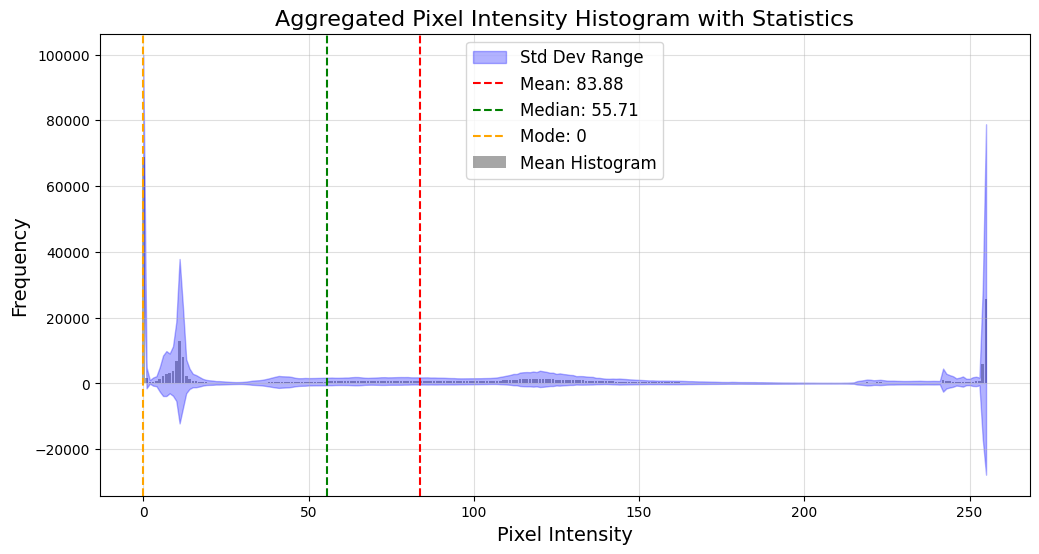

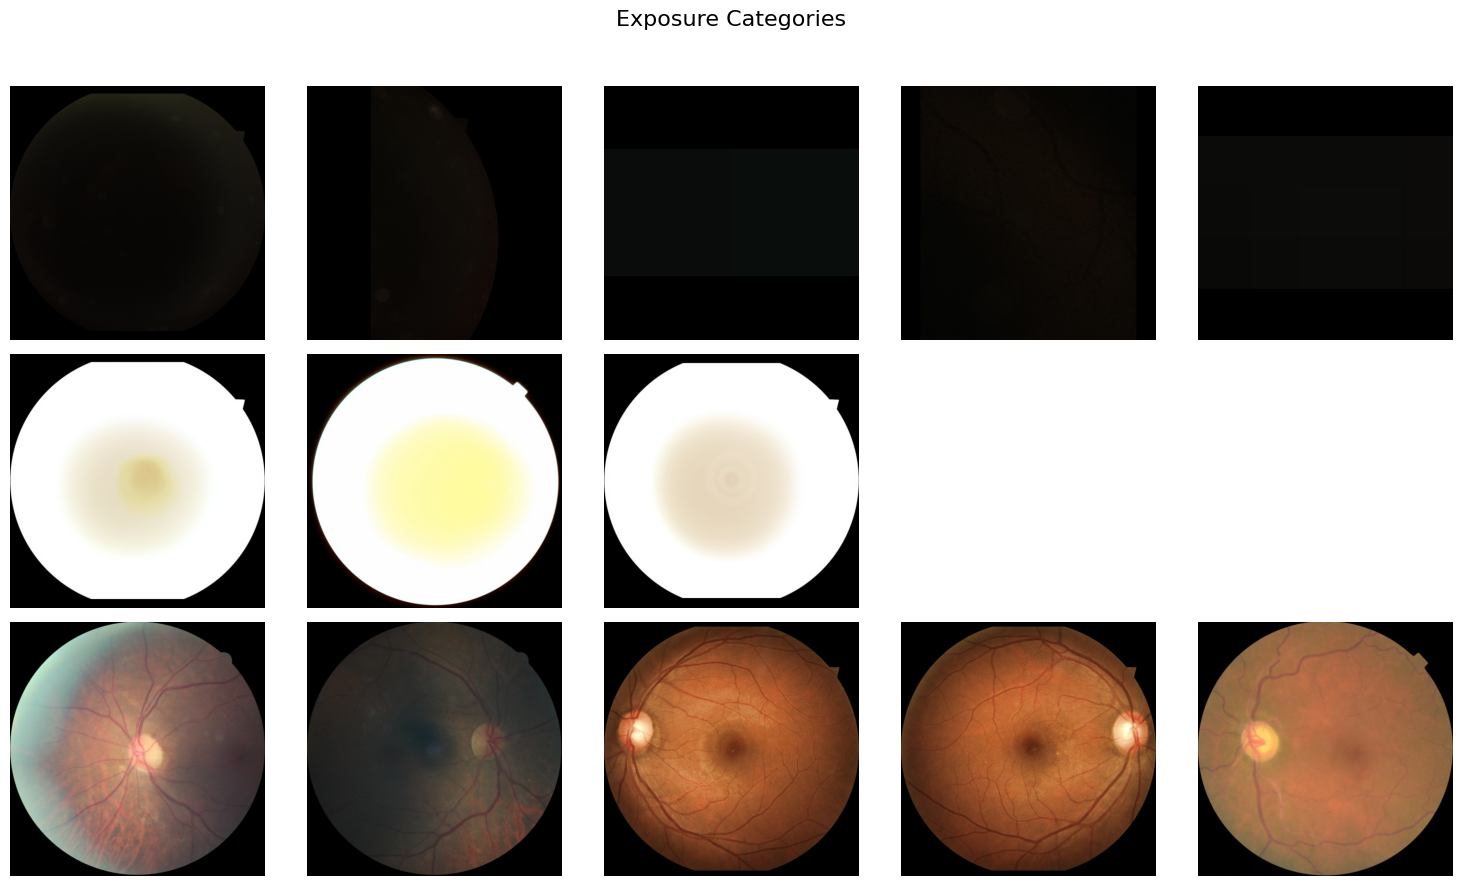

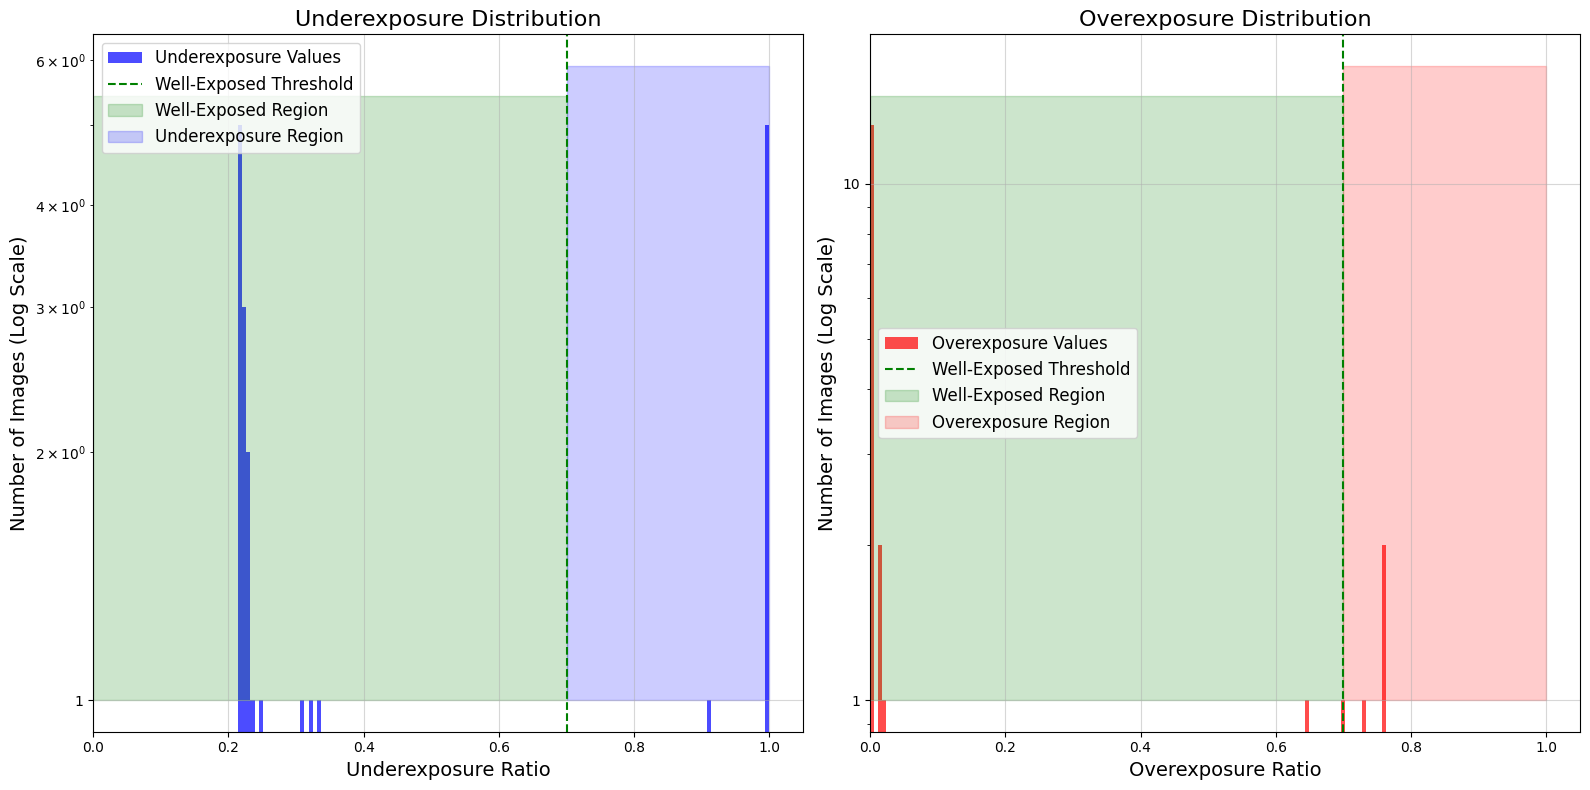

In [30]:
if __name__ == '__main__':
    plt.style.use('default')
    image_folder = 'Data/sample'
    output_folder = 'Data/temp'
    csv_path = 'Data/trainLabels.csv'
    # Process images and get results
    results_df, aggregated_histogram, std_histogram = process_images_with_histogram_statistics(image_folder, csv_path, output_folder)
    # Generate and display summary table
    summary_table = generate_summary_table(results_df)
    print("\nExposure Summary:")
    print(summary_table)
    # Save the results and summary table
    results_df.to_csv("Data/exposure_results_with_labels.csv", index=False)
    summary_table.to_csv("Data/exposure_summary_table.csv")
    
    plot_histogram_statistics(aggregated_histogram, std_histogram)
    # Display 3x5 subplot of images
    display_exposure_subplots(results_df, output_folder, num_images=5)
    # Plot the distribution of actual exposure values
    plot_image_exposure_distributions(results_df)

In [31]:
# # Load CSV and associate image paths
# def load_data(csv_path, image_folder):
#     df = pd.read_csv(csv_path)
#     df["image_path"] = df["image"].apply(lambda x: os.path.join(image_folder, f"{x}.jpeg"))
#     return df

In [32]:
# # Split data into Train, Validation, and Test sets
# def split_data(df, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, random_state=42):
#     assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."
#     
#     # First split into Train and Temp (Val + Test)
#     train_df, temp_df = train_test_split(df, 
#         test_size=(1 - train_ratio), 
#         stratify=df["level"], 
#         random_state=random_state)
#     
#     # Then split Temp into Validation and Test
#     val_df, test_df = train_test_split(temp_df, 
#         test_size=(test_ratio / (val_ratio + test_ratio)), 
#         stratify=temp_df["level"], 
#         random_state=random_state)
#     
#     return train_df, val_df, test_df

In [33]:
# # Load images into memory
# def load_images(df):
#     images = []
#     labels = []
#     for _, row in df.iterrows():
#         image_path = row["image_path"]
#         label = row["level"]
#         try:
#             # Load image and convert to RGB
#             image = Image.open(image_path).convert("RGB")
#             images.append(image)
#             labels.append(label)
#         except Exception as e:
#             print(f"Error loading image {image_path}: {e}")
#     return images, labels

In [34]:
# # Main script
# if __name__ == "__main__":
#     csv_path = "trainLabels.csv"
#     image_folder = "Cropped_W_Exposure"
#     
#     # Load dataset
#     df = load_data(csv_path, image_folder)
#     
#     # Split dataset
#     train_df, val_df, test_df = split_data(df)
#     
#     print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")
#     
#     # Load images into memory
#     train_images, train_labels = load_images(train_df)
#     val_images, val_labels = load_images(val_df)
#     test_images, test_labels = load_images(test_df)
#     
#     print(f"Loaded {len(train_images)} train images, {len(val_images)} validation images, {len(test_images)} test images.")